# CS4487 - Machine Learning
# Lecture 9b - Neural Networks, Deep Learning
## Dr. Antoni B. Chan
### Dept. of Computer Science, City University of Hong Kong

# Outline
- History
- Perceptron
- **Multi-layer perceptron (MLP)**
- Convolutional neural network (CNN)
- Autoencoder (AE)

In [30]:
# setup
%matplotlib inline
import IPython.core.display         # setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats

rbow = plt.get_cmap('rainbow')

In [31]:
# use TensorFlow backend
%env KERAS_BACKEND=tensorflow     
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Conv2D, Flatten, Input
import keras
import tensorflow
import logging
logging.basicConfig()
import struct

env: KERAS_BACKEND=tensorflow


In [32]:
def plot_history(history): 
    fig, ax1 = plt.subplots()
    
    ax1.plot(history.history['loss'], 'r', label="training loss ({:.6f})".format(history.history['loss'][-1]))
    ax1.plot(history.history['val_loss'], 'r--', label="validation loss ({:.6f})".format(history.history['val_loss'][-1]))
    ax1.grid(True)
    ax1.set_xlabel('iteration')
    ax1.legend(loc="best", fontsize=9)    
    ax1.set_ylabel('loss', color='r')
    ax1.tick_params('y', colors='r')

    if 'acc' in history.history:
        ax2 = ax1.twinx()

        ax2.plot(history.history['acc'], 'b', label="training acc ({:.4f})".format(history.history['acc'][-1]))
        ax2.plot(history.history['val_acc'], 'b--', label="validation acc ({:.4f})".format(history.history['val_acc'][-1]))

        ax2.legend(loc="best", fontsize=9)
        ax2.set_ylabel('acc', color='b')        
        ax2.tick_params('y', colors='b')

In [33]:
def show_imgs(W_list, nc=10, highlight_green=None, highlight_red=None, titles=None):
    nfilter = len(W_list)
    nr = (nfilter - 1) // nc + 1
    for i in range(nr):
        for j in range(nc):
            idx = i * nc + j
            if idx == nfilter:
                break
            plt.subplot(nr, nc, idx + 1)
            cur_W = W_list[idx]
            plt.imshow(cur_W,cmap='gray', interpolation='nearest')  
            if titles is not None:
                plt.title(titles % idx)
            
            if ((highlight_green is not None) and highlight_green[idx]) or \
               ((highlight_red is not None) and highlight_red[idx]): 
                ax = plt.gca()
                if highlight_green[idx]:
                    mycol = '#00FF00'
                else:
                    mycol = 'r'
                for S in ['bottom', 'top', 'right', 'left']:
                    ax.spines[S].set_color(mycol)
                    ax.spines[S].set_lw(2.0)
                ax.xaxis.set_ticks_position('none')               
                ax.yaxis.set_ticks_position('none')
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                plt.gca().set_axis_off()


In [34]:
def read_32int(f):
    return struct.unpack('>I', f.read(4))[0]
def read_img(img_path):
    with open(img_path, 'rb') as f:
        magic_num = read_32int(f)
        num_image = read_32int(f)
        n_row = read_32int(f)
        n_col = read_32int(f)
        #print 'num_image = {}; n_row = {}; n_col = {}'.format(num_image, n_row, n_col)
        res = []
        npixel = n_row * n_col
        res_arr = fromfile(f, dtype='B')
        res_arr = res_arr.reshape((num_image, n_row, n_col), order='C')
        #print 'image data shape = {}'.format(res_arr.shape)
        return num_image, n_row, n_col, res_arr    
def read_label(label_path):
    with open(label_path, 'rb') as f:
        magic_num = read_32int(f)
        num_label = read_32int(f)
        #print 'num_label = {}'.format(num_label)
        res_arr = fromfile(f, dtype='B')
        #print res_arr.shape
        #res_arr = res_arr.reshape((num_label, 1))
        res_arr = res_arr.ravel()
        #print 'label data shape = {}'.format(res_arr.shape)
        return num_label, res_arr

# Example on MNIST Dataset
- Images are 28x28, digits 0-9
  - 6,000 for training
  - 10,000 for testing

In [35]:
n_train, nrow, ncol, trainimg = read_img('data/train-images.idx3-ubyte')
_, trainY = read_label('data/train-labels.idx1-ubyte')
n_test, _, _, testimg = read_img('data/t10k-images.idx3-ubyte')
_, testY = read_label('data/t10k-labels.idx1-ubyte')

# for demonstration we only use 10% of the training data
sample_index = range(0, trainimg.shape[0], 10)
trainimg  = trainimg[sample_index]
trainY    = trainY[sample_index]
print(trainimg.shape)
print(trainY.shape)
print(testimg.shape)
print(testY.shape)

(6000, 28, 28)
(6000,)
(10000, 28, 28)
(10000,)


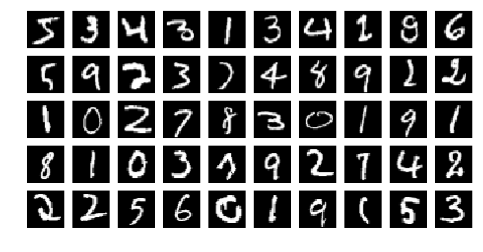

In [36]:
# Example images
plt.figure(figsize=(8,4))
show_imgs(trainimg[0:50])

# Pre-processing
- Reshape images into vectors
- map to [0,1], then subtract the mean

In [37]:
# Reshape the images to a vector
# and map the data to [0,1]
trainXraw = trainimg.reshape((len(trainimg), -1), order='C') / 255.0
testXraw = testimg.reshape((len(testimg), -1), order='C') / 255.0

# center the image data (but don't change variance)
scaler = preprocessing.StandardScaler(with_std=False)
trainX = scaler.fit_transform(trainXraw)
testX  = scaler.transform(testXraw)

# convert class labels to binary indicators
trainYb = keras.utils.np_utils.to_categorical(trainY)

print(trainX.shape)
print(trainYb.shape)

(6000, 784)
(6000, 10)


- Generate a fixed validation set
  - use vtrainX for training and validX for validation

In [38]:
# generate a fixed validation set using 10% of the training set
vtrainX, validX, vtrainYb, validYb = \
  model_selection.train_test_split(trainX, trainYb, 
  train_size=0.9, test_size=0.1, random_state=4487)

# validation data
validset  = (validX, validYb)

# MNIST - Logistic Regression (0-hidden layers)
- Training procedure
  - We specify the validation set so that it will be fixed when we change the `random_state` to randomly initialize the weights.
  - Train on the non-validation training data.
  - Use a larger batch size to speed up the algorithm


In [39]:

# initialize random seed
random.seed(4487); tensorflow.set_random_seed(4487)

# build the network
nn = Sequential()
nn.add(Dense(units=10, input_dim=784, activation='softmax'))

# early stopping criteria
earlystop = keras.callbacks.EarlyStopping(
               monitor='val_acc',             # use validation accuracy for stopping
               min_delta=0.0001, patience=5, 
               verbose=1, mode='auto')
callbacks_list = [earlystop]

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(lr=0.05, momentum=0.9, nesterov=True), 
           metrics=['accuracy']  # also calculate accuracy during training
          )

history = nn.fit(vtrainX, vtrainYb, epochs=100, batch_size=50, 
                 callbacks=callbacks_list, 
                 validation_data=validset,  # specify the validation set
                 verbose=False)

Epoch 00007: early stopping


test accuracy: 0.8921


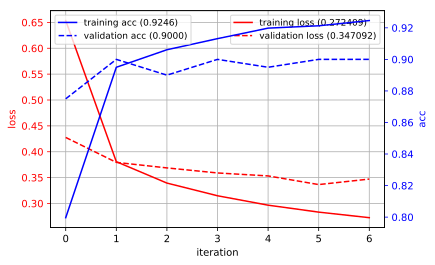

In [40]:
plot_history(history)

predY = nn.predict_classes(testX, verbose=False)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

- Examine the weights of the network
  - use `get_layer` to access indexed layer in the network
    - layer 0 is the input layer.
  - use `get_weights` to get the weights/biases for a layer.

In [41]:
nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [42]:
params = nn.get_layer(index=0).get_weights()
print(params)

[array([[ 0.06149667, -0.00956881,  0.04494786, ..., -0.01983179,
        -0.01988732, -0.04903082],
       [-0.03783249,  0.05561111,  0.01096175, ...,  0.00689876,
        -0.03800327,  0.05169382],
       [ 0.0464403 , -0.06389185, -0.0054566 , ..., -0.08001423,
         0.00840039,  0.06919765],
       ...,
       [-0.08192953, -0.01071142, -0.08111438, ..., -0.00769493,
         0.02033912,  0.0334817 ],
       [ 0.02797209,  0.06162796,  0.04971624, ..., -0.07365877,
        -0.06210516,  0.04514118],
       [-0.0757691 , -0.0307025 ,  0.03168748, ...,  0.05234558,
         0.01123877, -0.05992332]], dtype=float32), array([-0.8677263 , -1.0924443 ,  0.35358974,  0.42186356, -0.5062295 ,
        0.71167785, -0.44736758, -0.3970873 ,  1.2463356 ,  0.5773874 ],
      dtype=float32)]


- Reshape the weights into an image
  - input images that match the weights will have high response for that class.

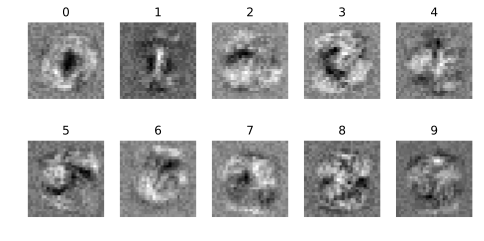

In [77]:
W = params[0]
filter_list = [W[:,i].reshape((28,28)) for i in range(W.shape[1])]
plt.figure(figsize=(8,4))
show_imgs(filter_list, nc=5, titles="%d")

# MNIST - 1-hidden layer
- Add 1 hidden layer with 50 ReLu nodes
  - each node is extracting a feature from the input image

In [78]:
# initialize random seed
random.seed(4487); tensorflow.set_random_seed(4487)

# build the network
nn = Sequential()
nn.add(Dense(units=50, input_dim=784, activation='relu')) # hidden layer
nn.add(Dense(units=10, activation='softmax'))  # output layer

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(lr=0.1, momentum=0.9, nesterov=True), 
           metrics=['accuracy'])
history = nn.fit(vtrainX, vtrainYb, epochs=100, batch_size=50, 
                 callbacks=callbacks_list, 
                 validation_data=validset, verbose=False)

Epoch 00012: early stopping


test accuracy: 0.9381


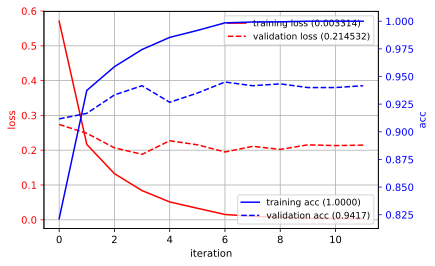

In [45]:
plot_history(history)

predY = nn.predict_classes(testX, verbose=False)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

- Examine the weights of the hidden layer
  - $h_i = \sigma(\mathbf{w}_i^T \mathbf{x})$
  - each weight vector is a "pattern prototype" that the node will match
- The hidden nodes look for local structures:
  - oriented edges, curves, other local structures

In [79]:
nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 50)                39250     
_________________________________________________________________
dense_36 (Dense)             (None, 10)                510       
Total params: 39,760
Trainable params: 39,760
Non-trainable params: 0
_________________________________________________________________


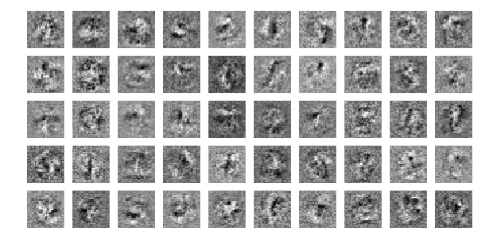

In [47]:
W = nn.get_layer(index=0).get_weights()[0]
filter_list = [W[:,i].reshape((28,28)) for i in range(W.shape[1])]
plt.figure(figsize=(8,4))
show_imgs(filter_list, nc=10)

- Examine the weights of the 2nd layer (output)
  - $y_j = \sigma(\mathbf{w}_j^T\mathbf{h})$
  - recall the hidden-layer outputs $h$ are always non-negative.
    - positive value in $\mathbf{w}_j$ -> class $j$ should have j-th pattern
    - negative value in $\mathbf{w}_j$ -> class $j$ shouldn't have j-th pattern

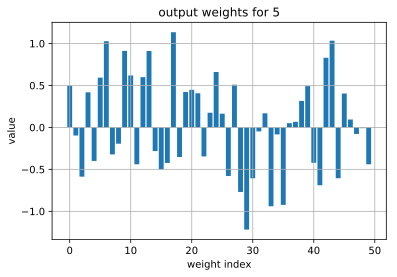

In [48]:
W = nn.get_layer(index=1).get_weights()[0]
d = 5
plt.figure()
plt.bar(arange(0,W.shape[0]),W[:,d]); plt.grid(True);
plt.xlabel('weight index'); plt.ylabel('value')
plt.title('output weights for {}'.format(d));

- For "5", finds local image parts that correspond to 5
  - should have (green boxes):
    - horizontal line at top
    - semicircle on the botoom
  - shouldn't have (red boxes):
    - vertical line in top-right
    - verticle line in the middle

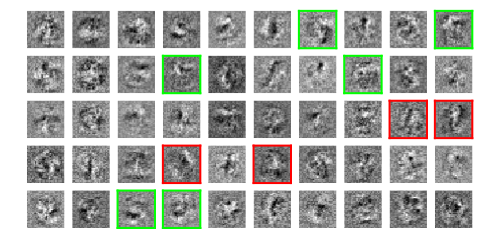

In [49]:
plt.figure(figsize=(8,4))
show_imgs(filter_list, nc=10,
          highlight_green=(W[:,d]>0.75), # positive weights are green
          highlight_red=(W[:,d]<-0.75))  # negative weights are red

# 1 Hidden layer with more nodes
- hidden layer with 200 nodes

In [50]:
# initialize random seed
random.seed(4487); tensorflow.set_random_seed(4487)

# build the network
nn = Sequential()
nn.add(Dense(units=200, input_dim=784, activation='relu'))
nn.add(Dense(units=10, activation='softmax'))

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(lr=0.1, momentum=0.9, nesterov=True), 
           metrics=['accuracy'])
history = nn.fit(vtrainX, vtrainYb, epochs=100, batch_size=50, 
                 callbacks=callbacks_list, 
                 validation_data=validset, verbose=False)

Epoch 00014: early stopping


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 200)               157000    
_________________________________________________________________
dense_17 (Dense)             (None, 10)                2010      
Total params: 159,010
Trainable params: 159,010
Non-trainable params: 0
_________________________________________________________________
test accuracy:  0.9438


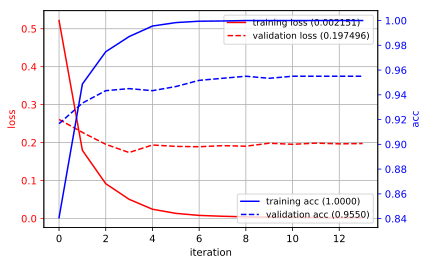

In [51]:
nn.summary()

plot_history(history)

predY = nn.predict_classes(testX, verbose=False)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy: ", acc)

- hidden layer with 1000 nodes

In [52]:
# initialize random seed
random.seed(4487); tensorflow.set_random_seed(4487)

# build the network
nn = Sequential()
nn.add(Dense(units=1000, input_dim=784, activation='relu'))
nn.add(Dense(units=10, activation='softmax'))

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(lr=0.1, momentum=0.9, nesterov=True), 
          metrics=['accuracy'])
history = nn.fit(vtrainX, vtrainYb, epochs=100, batch_size=50, 
                 callbacks=callbacks_list, 
                 validation_data=validset, verbose=False)

Epoch 00014: early stopping


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 1000)              785000    
_________________________________________________________________
dense_19 (Dense)             (None, 10)                10010     
Total params: 795,010
Trainable params: 795,010
Non-trainable params: 0
_________________________________________________________________
test accuracy: 0.9459


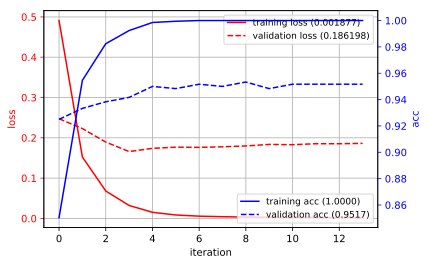

In [53]:
nn.summary()
plot_history(history)

predY = nn.predict_classes(testX, verbose=False)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

- 2 hidden layers
  - input (28x28) -> 500 nodes -> 500 nodes -> output
  - Slightly better

In [54]:
# initialize random seed
random.seed(4487); tensorflow.set_random_seed(4487)

# build the network
nn = Sequential()
nn.add(Dense(units=500, input_dim=784, activation='relu'))
nn.add(Dense(units=500, activation='relu'))
nn.add(Dense(units=10, activation='softmax'))

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(lr=0.1, momentum=0.9, nesterov=True), 
          metrics=['accuracy'])
history = nn.fit(vtrainX, vtrainYb, epochs=100, batch_size=50, 
                 callbacks=callbacks_list, 
                 validation_data=validset, verbose=False)

Epoch 00012: early stopping


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 500)               392500    
_________________________________________________________________
dense_21 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_22 (Dense)             (None, 10)                5010      
Total params: 648,010
Trainable params: 648,010
Non-trainable params: 0
_________________________________________________________________
test accuracy: 0.9509


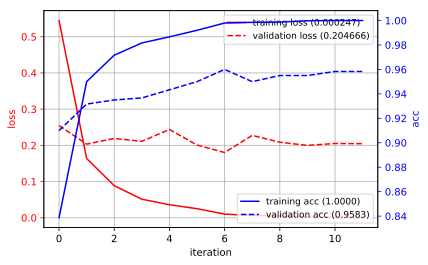

In [55]:
nn.summary()
plot_history(history)

predY = nn.predict_classes(testX, verbose=False)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

# Outline
- History
- Perceptron
- Multi-layer perceptron (MLP)
- **Convolutional neural network (CNN)**
- Autoencoder (AE)

# Image Inputs and Neural Networks
- In the MLP, each node takes inputs from all other nodes in the previous layer. 
  - For image input, we transform the image into a vector, which is the input into the MLP.
    
<center>
<table><tr>
<td><img src="imgs/ducklings.jpg" width=300></td>
<td><img src="imgs/2d1d.svg" width=200></td>
<td><img src="imgs/neural_net.jpeg" width=300></td>
</tr></table></center>

- **Problem:** This ignores the spatial relationship between pixels in the image.
  - Images contain local structures 
    - groups of neighboring pixels correspond to visual structures (edges, corners, texture).
    - pixels far from each other are typically not correlated.

# Convolutional Neural Network (CNN)
- Use the spatial structure of the image
- 2D convolution filter
  - the weights $\mathbf{W}$ form a 2D filter template
  - filter response: $h = f(\sum_{x,y} W_{x,y} P_{x,y})$
    - $\mathbf{P}$ is an image patch with the same size as $\mathbf{W}$.
- Convolution feature map
  - pass a sliding window over the image, and apply filter to get a _feature map_.
<center><img src="imgs/Convolution_schematic.gif" width=400></center>

- Convolution modes
  - **"valid"** mode - only compute feature where convolution filter has valid image values.
    - size of feature map is reduced.
<center><img src="imgs/conv-valid.gif" width=400></center>

- Convolution modes
  - **"same"** mode - zero-pad the border of the image
    - feature map is the same size as the input image.
<center><img src="imgs/conv-same.gif" width=400></center>

- Convolutional layer
  - **Input:** HxW image with C channels
    - For example, in the first layer, C=3 for RGB channels.
    - defines a 3D volume: C x H x W
  - **Features:** apply F convolution filters to get F feature maps.
    - Uses 3D convolution filters: weight volume is C x K x K
    - K is the spatial extent of the filter
  - **Output:** a feature map with F channels 
    - defines a 3D volume: F x H' x W'
    
<center><img src="imgs/depthcol2.jpeg" width=350></center>

- Convolutional Neural Network
  - Concatenate several convolutional layers.
  - From layer to layer
    - spatial resolution decreases
    - number of feature maps increases
  - Can extract high-level features in the final layers

<center><img src="imgs/cnn.jpeg" width=500></center>

  - Spatial sub-sampling
    - reduce the feature map size by subsampling feature maps between convolutional layers
      - *stride* for convolution filter - step size when moving the windows across the image. <center><img src="imgs/conv-stride.gif" width=300></center>      
      - *max-pooling* - use the maximum over the pooling window
        - gathers features together, makes it robust to small changes in configuration of features
<center><img src="imgs/conv-pool.png" width=300></center>

  - Fully-connected MLP
    - after several convolutional layers, input the feature map into an MLP to get the final classification.
<center><img src="imgs/mylenet.png" width=800></center>

# Example 
- Object classification
  - Each layer shows its feature maps for the example image.
    - early layers extract low-level (visual) features
    - later layers extract high-level (semantic) features.
<center><img src="imgs/convnet.jpeg" width=800></center>

# Advantages of Convolution Layers
- The convolutional filters extract the same features throughout the image.
  - Good when the object can appear in different locations of the image.
- Pooling makes it robust to changes in feature configuration, and translation of the object.
- The number of parameters is small compared to Dense (Fully-connected) layer
  - Example: input is C x H x W, and output is F x H x W
    - Number of MLP parameters: (CHW+1) x (FHW)
    - Number of CNN parameters: (CKK+1) x (FKK)

# Example on MNIST
- Pre-processing
  - scale to [0,1]
  - 4-D tensor: (sample, channel, height, width)
    - channel = 1 (grayscale)
  - create training/validation sets

In [56]:
# scale to 0-1
trainI = (trainimg.reshape((6000,1,28,28)) / 255.0)
testI  = (testimg.reshape((10000,1,28,28)) / 255.0)
print(trainI.shape)
print(testI.shape)

(6000, 1, 28, 28)
(10000, 1, 28, 28)


- Generate fixed training and validation sets

In [57]:
# generate fixed validation set of 10% of the training set
vtrainI, validI, vtrainYb, validYb = \
  model_selection.train_test_split(trainI, trainYb, 
  train_size=0.9, test_size=0.1, random_state=4487)

validsetI = (validI, validYb)

# Shallow CNN Architecture
- Architecture
  - 1 Convolution layer
    - 1x5x5 kernel, 10 features
    - _stride_ = 2 (step-size between sliding windows)
    - No pooling here since the image input is small (28x28)
    - Input: 1x28x28 (grayscale image) -> Output: 10x14x14
  - 1 fully-connected layer (MLP), 50 nodes
    - Input: 10x14x14=1960 -> Output: 50
  - Classification output node

In [58]:
# initialize random seed
random.seed(4487); tensorflow.set_random_seed(4487)

# build the network
nn = Sequential()
nn.add(Conv2D(10, (5,5),        # channel, kerne size
              strides=(2,2),    # stride
              activation='relu',
              padding='same',   # convolution padding
              data_format='channels_first', # using channel-first format              
              input_shape=(1,28,28)))
nn.add(Flatten())   # flatten the feature map into a vector to apply Dense layers
nn.add(Dense(units=50, activation='relu'))
nn.add(Dense(units=10, activation='softmax'))

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(lr=0.02, momentum=0.9, nesterov=True), 
          metrics=['accuracy'])
history = nn.fit(vtrainI, vtrainYb, epochs=100, batch_size=50, 
                 callbacks=callbacks_list, 
                 validation_data=validsetI, verbose=False)

Epoch 00026: early stopping


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 10, 14, 14)        260       
_________________________________________________________________
flatten_2 (Flatten)          (None, 1960)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 50)                98050     
_________________________________________________________________
dense_24 (Dense)             (None, 10)                510       
Total params: 98,820
Trainable params: 98,820
Non-trainable params: 0
_________________________________________________________________
test accuracy: 0.9543


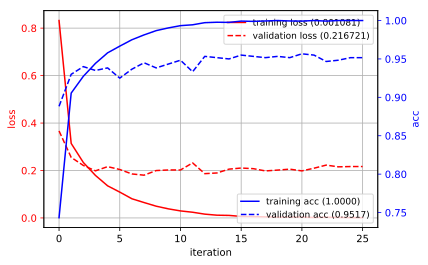

In [59]:
nn.summary()

plot_history(history)

predY = nn.predict_classes(testI, verbose=False)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

- Visualize the convolutional filters
  - filters are looking for local stroke features
    - corners, edges, lines

(5, 5, 1, 10)


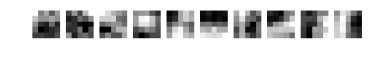

In [60]:
W = nn.get_layer(index=0).get_weights()[0]
print(W.shape)
flist = [squeeze(W[:,:,:,c]) for c in range(10)]
show_imgs(flist)

# Handling the Image Border
- How to handle the border of the image input when doing convolution?
- Two options:
  - "same" - zero-padding around the image border, so that the filter can be applied to all pixels in the image.
  - "valid" - only do convolution where there is valid image - reduces the image size slightly around the border
- (Usually "same" is better since it looks at structures around border)

# Deep CNN Architecture
- Deep Architecture
  - 3 Convolutional layers
    - 1x5x5 kernel, stride 2, 10 features
      - output feature map is 10x14x14
    - 10x3x3 kernel, stride 2, 40 features
      - output feature map is 40x7x7
   - 40x3x3 kernel, stride 1, 80 features
     - output feature map is 80x7x7
     - set stride as 1 to avoid reducing the feature map too much)
  - 1 fully-connected layer
    - 50 nodes
      - input: 80x7x7=3920 -> output: 50
  - Classification output node

In [61]:
# initialize random seed
random.seed(4487); tensorflow.set_random_seed(4487)

# build the network
nn = Sequential()
nn.add(Conv2D(10, (5,5), strides=(2,2), 
              activation='relu', input_shape=(1,28,28),
              padding='same', data_format='channels_first'))
nn.add(Conv2D(40, (5,5), strides=(2,2), activation='relu',
              padding='same', data_format='channels_first'))
nn.add(Conv2D(80, (5,5), strides=(1,1), activation='relu',
              padding='same', data_format='channels_first')) 
nn.add(Flatten())
nn.add(Dense(units=50, activation='relu'))
nn.add(Dense(units=10, activation='softmax'))

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(lr=0.02, momentum=0.9, nesterov=True), 
          metrics=['accuracy'])
history = nn.fit(vtrainI, vtrainYb, epochs=100, batch_size=50, 
                 callbacks=callbacks_list, 
                 validation_data=validsetI, verbose=False)

Epoch 00017: early stopping


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 10, 14, 14)        260       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 40, 7, 7)          10040     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 80, 7, 7)          80080     
_________________________________________________________________
flatten_3 (Flatten)          (None, 3920)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 50)                196050    
_________________________________________________________________
dense_26 (Dense)             (None, 10)                510       
Total params: 286,940
Trainable params: 286,940
Non-trainable params: 0
_________________________________________________________________
test

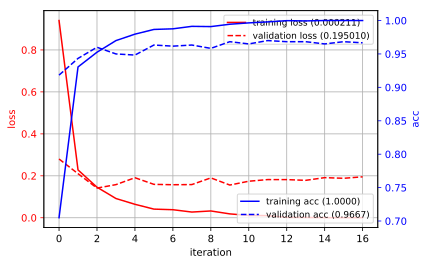

In [62]:
nn.summary()
plot_history(history)

predY = nn.predict_classes(testI, verbose=False)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy: ", acc)

# Regularization with "Dropout"
- During training, randomly "drop out" each node with probability $p$
  - a dropped-out node is not used for calculating the prediction or weight updating.
  - trains a reduced network in each iteration.

<center><img src="imgs/dropout.jpeg" width=500></center>

- During test time, use all the nodes for prediction and scale output by $p$.
  - Similar to creating an ensemble of networks, and then averaging the predictions.
- Prevents overfitting
  - also improves the training time.



- Dropout is implemented as a layer.
- Example: 
  - apply dropout layer after last feature layer and 1st dense layer.
  - accuracy improves

In [63]:
# initialize random seed
random.seed(4487); tensorflow.set_random_seed(4487)

# build the network
nn = Sequential()
nn.add(Conv2D(10, (5,5), strides=(2,2), activation='relu',
              input_shape=(1,28,28),
              padding='same', data_format='channels_first'))
nn.add(Conv2D(40, (5,5), strides=(2,2), activation='relu',
              padding='same', data_format='channels_first'))
nn.add(Conv2D(80, (5,5), strides=(1,1), activation='relu',
              padding='same',  data_format='channels_first'))
nn.add(Dropout(rate=0.5, seed=44))   # dropout layer! (need to specify the seed)
nn.add(Flatten())
nn.add(Dense(units=50, activation='relu'))
nn.add(Dropout(rate=0.5, seed=45))   # dropout layer!
nn.add(Dense(units=10, activation='softmax'))

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(lr=0.02, momentum=0.9, nesterov=True), 
          metrics=['accuracy'])
history = nn.fit(vtrainI, vtrainYb, epochs=100, batch_size=50, 
                 callbacks=callbacks_list, 
                 validation_data=validsetI, verbose=False)

Epoch 00018: early stopping


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 10, 14, 14)        260       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 40, 7, 7)          10040     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 80, 7, 7)          80080     
_________________________________________________________________
dropout_1 (Dropout)          (None, 80, 7, 7)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 3920)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 50)                196050    
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
__________

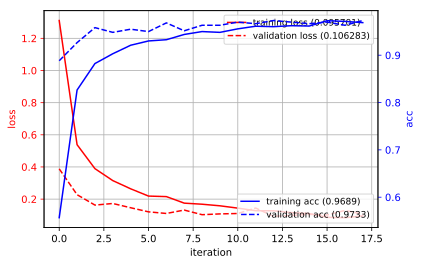

In [64]:
nn.summary()
plot_history(history)

predY = nn.predict_classes(testI, verbose=False)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

# Regularization with Weight Decay
- Another way to regularize the network is to use "weight decay"
  - Add a penalty term to the loss function
    - larger weights impose higher penalty
    - $L = Loss + \alpha \sum_{i} w_i^2$

- Apply regularizers on selected later layers.
  - About the same accuracy

In [65]:
# initialize random seed
random.seed(4487); tensorflow.set_random_seed(4487)

# build the network
nn = Sequential()
nn.add(Conv2D(10, (5,5), strides=(2,2), activation='relu',
              input_shape=(1,28,28),
              padding='same', data_format='channels_first'))
nn.add(Conv2D(40, (5,5), strides=(2,2), activation='relu',
              padding='same', data_format='channels_first'))
nn.add(Conv2D(80, (5,5), strides=(1,1), activation='relu',
              kernel_regularizer=keras.regularizers.l2(0.0001),  # L2 regularizer
              padding='same', data_format='channels_first'))
nn.add(Flatten())
nn.add(Dense(units=50, activation='relu', 
             kernel_regularizer=keras.regularizers.l2(0.0001))) # L2 regularizer
nn.add(Dense(units=10, activation='softmax'))

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(lr=0.02, momentum=0.9, nesterov=True), 
          metrics=['accuracy'])
history = nn.fit(vtrainI, vtrainYb, epochs=100, batch_size=50, 
                 callbacks=callbacks_list, 
                 validation_data=validsetI, verbose=False)

Epoch 00008: early stopping


test accuracy: 0.9605


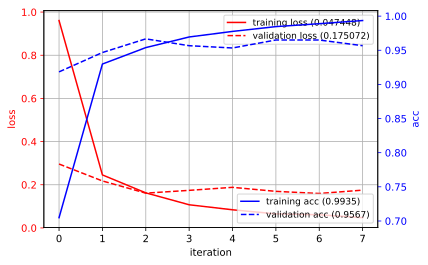

In [66]:
plot_history(history)

predY = nn.predict_classes(testI, verbose=False)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

# Data augmentation
- artificially permute the data to increase the dataset size
  - goal: make the network invariant to the permutations
  - examples: translate image, flip image, add pixel noise, rotate image, deform image, etc.
<center><img src="imgs/dogs.png" width=500></center>

In [67]:
from keras.preprocessing.image import ImageDataGenerator

# build the data augmenter
datagen = ImageDataGenerator(
    rotation_range=10,         # image rotation
    width_shift_range=0.2,     # image shifting
    height_shift_range=0.2,    # image shifting
    shear_range=0.1,           # shear transformation
    zoom_range=0.1,            # zooming
    data_format='channels_first')

# fit (required for some normalization augmentations)
datagen.fit(vtrainI)

In [68]:
img = vtrainI[0]
imgs = [img[0]]

cnt = 0
for augimg, augy in datagen.flow(img.reshape(1,1,~28,28), [1], batch_size=1):
    imgs.append(augimg[0,0,:,:])
    cnt += 1
    if cnt > 8:
        # we need to break the loop by hand because
        # the generator loops indefinitely
        break

- Example of original (top-left) and augmented data

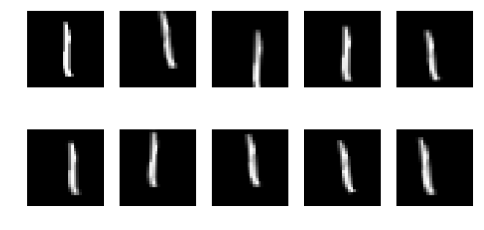

In [69]:
plt.figure(figsize=(8,4))
show_imgs(imgs, nc=5)

- Train with `fit_generator`
  - passes data through the generator first
  - runs generator and fit in parallel

In [70]:
# initialize random seed
random.seed(4487); tensorflow.set_random_seed(4487)

# build the network
nn = Sequential()
nn.add(Conv2D(10, (5,5), strides=(2,2), activation='relu', 
              input_shape=(1,28,28),
              padding='same', data_format='channels_first'))
nn.add(Conv2D(40, (5,5), strides=(2,2), activation='relu',
              padding='same', data_format='channels_first'))
nn.add(Conv2D(80, (5,5), strides=(1,1), activation='relu',
              padding='same',  data_format='channels_first'))
nn.add(Dropout(rate=0.5, seed=44))
nn.add(Flatten())
nn.add(Dense(units=50, activation='relu'))
nn.add(Dropout(rate=0.5, seed=45))
nn.add(Dense(units=10, activation='softmax'))

# compile the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(lr=0.02, momentum=0.9, nesterov=True), 
          metrics=['accuracy'])

# pass data through augmentor and fit
# runs data-generator and fit in parallel
history = nn.fit_generator(
            datagen.flow(vtrainI, vtrainYb, batch_size=50),  # data from generator
            steps_per_epoch=len(vtrainI)/50,    # should be number of batches per epoch
            epochs=100,
            callbacks=callbacks_list, 
            validation_data=validsetI, verbose=False)

Epoch 00016: early stopping


- data augmentation increases accuracy.

test accuracy: 0.9661


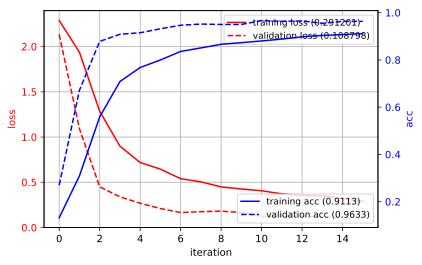

In [71]:
plot_history(history)

predY = nn.predict_classes(testI, verbose=False)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

# Data augmentation with noise
- Also add per-pixel noise to the image for data augmentation.
  - define a function to add noise
  - set it as the `preprocessing_function`

In [72]:
def add_gauss_noise(X, sigma2=0.05):
    # add Gaussian noise with zero mean, and variance sigma2
    return X + random.normal(0, sigma2, X.shape)

# build the data augmenter
datagen = ImageDataGenerator(
    rotation_range=10,         # image rotation
    width_shift_range=0.2,     # image shifting
    height_shift_range=0.2,    # image shifting
    shear_range=0.1,           # shear transformation
    zoom_range=0.1,            # zooming
    preprocessing_function=add_gauss_noise, 
    data_format='channels_first')

# fit (required for some normalization augmentations)
datagen.fit(vtrainI)

- Example: original image (top-left) and augmented data

In [73]:
img = vtrainI[0]
imgs = [img[0]]

cnt = 0
for augimg, augy in datagen.flow(img.reshape(1,1,28,28), [1], batch_size=1):
    imgs.append(augimg[0,0,:,:])
    cnt += 1
    if cnt > 8:
        # we need to break the loop by hand because
        # the generator loops indefinitely
        break

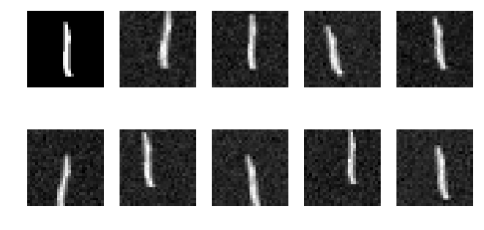

In [74]:
plt.figure(figsize=(8,4))
show_imgs(imgs, nc=5)

- Train with augmented data: transformations and per-pixel noise
  - the dataset changes each epoch, so validation error will change a lot.
  - we disable early stopping and just let it run for 100 epochs.

In [75]:
# initialize random seed
random.seed(4487); tensorflow.set_random_seed(4487)

# build the network
nn = Sequential()
nn.add(Conv2D(10, (5,5), strides=(2,2), activation='relu', 
              input_shape=(1,28,28),
              padding='same', data_format='channels_first'))
nn.add(Conv2D(40, (5,5), strides=(2,2), activation='relu',
              padding='same', data_format='channels_first'))
nn.add(Conv2D(80, (5,5), strides=(1,1), activation='relu',
              padding='same',  data_format='channels_first'))
nn.add(Dropout(rate=0.5, seed=44))
nn.add(Flatten())
nn.add(Dense(units=50, activation='relu'))
nn.add(Dropout(rate=0.5, seed=45))
nn.add(Dense(units=10, activation='softmax'))

# compile the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(lr=0.02, momentum=0.9, nesterov=True), 
          metrics=['accuracy'])

# pass data through augmentor and fit
# runs data-generator and fit in parallel
history = nn.fit_generator(
            datagen.flow(vtrainI, vtrainYb, batch_size=50),  # data from generator
            steps_per_epoch=len(vtrainI)/50,    # should be number of batches per epoch
            epochs=100,
            validation_data=validsetI, verbose=False)

- Results improved!

test accuracy: 0.987


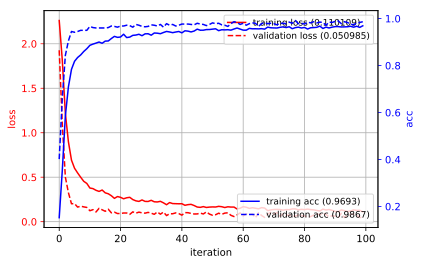

In [76]:
plot_history(history)

predY = nn.predict_classes(testI, verbose=False)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

# Comparison on MNIST
- For image data, CNN works better and has less parameters.
<table style="font-size:10pt;">
<tr>
  <th>Type</th>
  <th>No.Layers</th>
  <th>Architecture</th>
  <th>No.Parameters</th>
  <th>Test Accuracy</th>
</tr><tr>
  <td>LR</td>
  <td>1</td>
  <td>output(10)</td>
  <td>7,850</td>
  <td>0.8890</td>
</tr><tr>
  <td>MLP</td>
  <td>2</td>
  <td>ReLu(50), output(10)</td>
  <td>39,760</td>
  <td>0.9373</td>
</tr><tr>
  <td>MLP</td>
  <td>2</td>
  <td>Relu(200), output(10)</td>
  <td>159,010</td>
  <td>0.9431</td>
</tr><tr>
  <td>MLP</td>
  <td>2</td>
  <td>Relu(1000), output(10)</td>
  <td>795,010</td>
  <td>0.9453</td>
</tr><tr>
  <td>MLP</td>
  <td>3</td>
  <td>ReLu(500), Relu(500), output(10)</td>
  <td>648,010</td>
  <td>0.9523</td>
</tr><tr>
  <td>CNN</td>
  <td>3</td>
  <td>Conv(10x5x5), ReLu(50), output(10)</td>
  <td>98,820</td>
  <td>0.9537</td>
</tr><tr>
  <td>CNN</td>
  <td>5</td>
  <td>Conv(10x5x5), Conv(50x3x3), Conv(80x3x3), ReLu(50), output(10)</td>
  <td>286,940</td>
  <td>0.9693</td>
</tr><tr>
  <td>CNN (w/ dropout)</td>
  <td>5</td>
  <td>Conv(10x5x5), Conv(50x3x3), Conv(80x3x3), ReLu(50), output(10)</td>
  <td>286,940</td>
  <td>0.9756</td>
</tr><tr>
  <td>CNN (w/ dropout, data-augmentation)</td>
  <td>5</td>
  <td>Conv(10x5x5), Conv(50x3x3), Conv(80x3x3), ReLu(50), output(10)</td>
  <td>286,940</td>
  <td>0.9843</td>
</tr><tr>
  <td>CNN (w/ dropout, data-augmentation, noise)</td>
  <td>5</td>
  <td>Conv(10x5x5), Conv(50x3x3), Conv(80x3x3), ReLu(50), output(10)</td>
  <td>286,940</td>
  <td>0.9911</td>
</tr>
</table>

# Summary
- **Different types of neural networks**
  - _Perceptron_ - single node (similar to logistic regression)
  - _Multi-layer perceptron (MLP)_ - collection of perceptrons in layers
    - also called _Fully-connected layer_
  - _Convolutional neural network (CNN)_ - convolution filters for extracting local image features
- **Training**
  - optimize loss function using stochastic gradient descent

- **Advantages**
  - lots of parameters - large capacity to learn from large amounts of data
- **Disadvantages**
  - lots of parameters - easy to overfit data
    - need to regularize parameters (dropout, L2)
    - need to monitor the training process
  - sensitive to initialization, learning rate, training algorithm.

# Other things
- **Improving speed**
  - parallelize computations using GPU (Nvidia+CUDA)
- **Initialization**
  - the resulting network is still sensitive to initialization.
    - Solution: train several networks and combine them as an ensemble.
- **Training problems**
  - For very deep networks, the "vanishing gradient" problem can hinder convergence
    - Solution 1: "pre-train" parts of the network, then combine the parts and train the network as a whole to "fine-tune" it.
    - Solution 2: add auxiliary tasks in the middle layers to provide a stronger supervision signal.
<center><img src="imgs/googlenet2.png" width=800></center>

# Installing NN packages

- Keras - https://keras.io
  - Easy-to-use front-end for deep learning
  - Installation: https://keras.io/#installation
    - Also need to install a backend: Tensorflow or Theano.
      - Defaults to Tensorflow.  To switch to Theano, see [here](https://keras.io/backend/#switching-from-one-backend-to-another).
    - Might also need to install "np_utils".
  - API Documentation: https://keras.io/layers/core/

- Tensorflow - https://www.tensorflow.org
  - Google's NN engine
  - Installation: https://www.tensorflow.org/install/
  
- Theano - http://deeplearning.net/software/theano/
  - powerful NN engine
  - Installation: http://deeplearning.net/software/theano/install.html
    - for Mac, need to install Xcode and run it to get C++ compiler.
- Installation tips:
  - Use Anaconda installer
  - Tensorflow has GPU and non-GPU versions
    - `tensorflow` vs `tensorflow-gpu`

# References

- History:
  - http://www.andreykurenkov.com/writing/a-brief-history-of-neural-nets-and-deep-learning/

- Keras tutorials:
  - https://elitedatascience.com/keras-tutorial-deep-learning-in-python
  - https://blog.keras.io

- Online courses::
  - http://cs231n.github.io/neural-networks-1/
  - http://cs231n.github.io/convolutional-networks/